In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Imputer , Normalizer

def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map, red & blue
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
combined = [train_data, test_data]

In [3]:
train_data.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [4]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
#dropping Name , Ticket and PassengerId
train_data = train_data.drop(['Name'], axis=1)
train_data = train_data.drop(['Ticket'], axis=1)
train_data = train_data.drop(['PassengerId'], axis=1)

test_data = test_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Ticket'], axis=1)
combined = [train_data, test_data]

We see Cabin, Embarked and Sex are object values, we want to convert these to numeric values

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB


Cabin, Age and Embarked has missing values, we will need to handle this. Let's continue analyzing the dataset.

In [7]:
train_data.describe(include='all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,147,3
top,NaN,NaN,male,NaN,NaN,NaN,NaN,G6,S
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,4,644
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN,NaN


just by looking at the above data we can find meaningfull info. 

Around 38 % survived.
the mean age was 30 and there were mostly males on the Titanic. 

In [8]:
##fill in missing values with 'S' (the most common embarked value)
for dataset in combined:
    dataset[ 'Embarked' ] = dataset['Embarked'].fillna('S')

In [9]:
combined[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB


convert all object values to numerical

In [10]:
for dataset in combined:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    dataset['Sex'] = dataset['Sex'].map( {'male': 0, 'female': 1} ).astype(int)
    dataset['Cabin'] = pd.get_dummies( dataset.Cabin)

In [11]:
combined[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int32
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       891 non-null uint8
Embarked    891 non-null int32
dtypes: float64(2), int32(2), int64(4), uint8(1)
memory usage: 49.7 KB


In [12]:
##filling in missing values with mean
for dataset in combined:
    dataset[ 'Age' ] = dataset.Age.fillna( dataset.Age.mean() )
    dataset[ 'Fare' ] = dataset.Fare.fillna( dataset.Fare.mean() )
    dataset[ 'Cabin' ] = dataset.Cabin.fillna( dataset.Cabin.mean() )

In [13]:
combined[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int32
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       891 non-null uint8
Embarked    891 non-null int32
dtypes: float64(2), int32(2), int64(4), uint8(1)
memory usage: 49.7 KB


Now we have no missing values

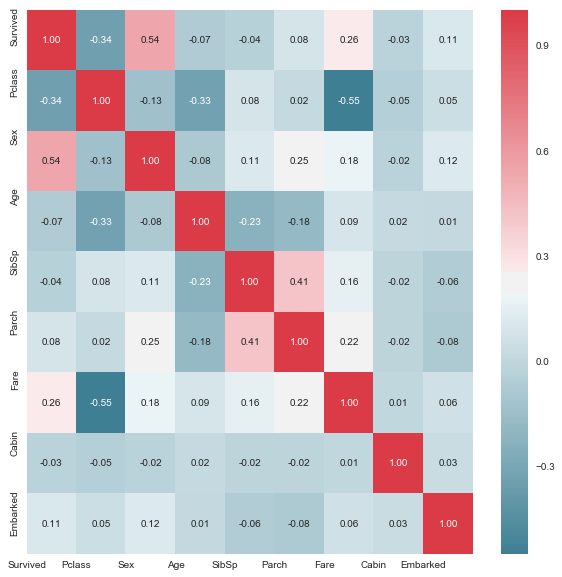

In [14]:
heatMap(combined[0])

When we look at the correlation of the variables, we see that Pclass, Sex and Fare has a strong relation to Survived.

In [15]:
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,0,0.188908
1,1,0.742038


In [16]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [17]:
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,0,0.339009
1,1,0.553571
2,2,0.389610


In [18]:
train_data['AgeBand'] = pd.cut(train_data['Age'], 5)
train_data[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.344168
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [19]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,AgeBand
0,0,3,0,22.0,1,0,7.2500,0,0,"(16.336, 32.252]"
1,1,1,1,38.0,1,0,71.2833,0,1,"(32.252, 48.168]"
2,1,3,1,26.0,0,0,7.9250,0,0,"(16.336, 32.252]"
3,1,1,1,35.0,1,0,53.1000,0,0,"(32.252, 48.168]"
4,0,3,0,35.0,0,0,8.0500,0,0,"(32.252, 48.168]"


In [20]:
for dataset in combined:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,AgeBand
0,0,3,0,1.0,1,0,7.2500,0,0,"(16.336, 32.252]"
1,1,1,1,2.0,1,0,71.2833,0,1,"(32.252, 48.168]"
2,1,3,1,1.0,0,0,7.9250,0,0,"(16.336, 32.252]"
3,1,1,1,2.0,1,0,53.1000,0,0,"(32.252, 48.168]"
4,0,3,0,2.0,0,0,8.0500,0,0,"(32.252, 48.168]"


In [21]:
train_data = train_data.drop(['AgeBand'], axis=1)
combine = [train_data, test_data]
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,0,2.0,0,0,7.8292,0,2
1,893,3,1,2.0,1,0,7.0000,0,0
2,894,2,0,3.0,0,0,9.6875,0,2
3,895,3,0,1.0,0,0,8.6625,0,0
4,896,3,1,1.0,1,1,12.2875,0,0


In [22]:
train_data['Alone'] = 0
train_data.loc[(train_data['SibSp'] > 0) | (train_data['Parch'] > 0), 'Alone'] = 1

test_data['Alone'] = 0
test_data.loc[(test_data['SibSp'] > 0) | (test_data['Parch'] > 0), 'Alone'] = 1

In [23]:
train_data[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean()


,Alone,Survived
0,0,0.303538
1,1,0.505650


In [24]:
train_data = train_data.drop(['Parch', 'SibSp'], axis=1)
test_data = test_data.drop(['Parch', 'SibSp'], axis=1)
combine = [train_data, test_data]

In [25]:
train_data['FareBand'] = pd.qcut(train_data['Fare'], 4)
train_data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [26]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_data = train_data.drop(['FareBand'], axis=1)
combine = [train_data, test_data]

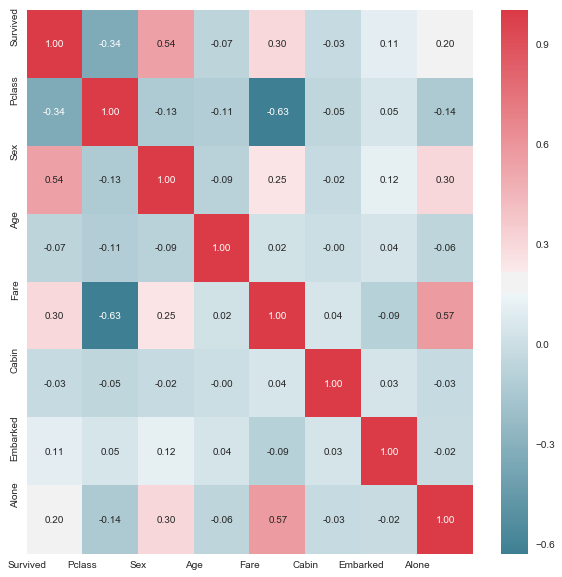

In [27]:
heatMap(train_data)

In [28]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop("PassengerId", axis=1).copy()

In [29]:
# Random Forest

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, Y_train)
Y_prediction = model.predict(X_test)
model.score(X_train, Y_train)
score = round(model.score(X_train, Y_train) * 100, 2)
score

85.75

In [30]:
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": Y_prediction
    })

In [31]:
#submission.to_csv('submission.csv', index=False)